# Imports

In [72]:
import numpy as np
import pandas as pd
import networkx as nx
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import collections
import scipy
import operator
from functools import reduce
import community.community_louvain as cmt
from networkx.algorithms.community import greedy_modularity_communities
import seaborn as sns
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import SpectralClustering as SC
from collections import defaultdict
import random
sns.set(rc={'figure.figsize':(16,9)})
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import itertools

# Datasets

<Big> <u>Routes</u></Big>

As of June 2014, the OpenFlights/Airline Route Mapper Route Database contains 67663 routes between 3321 airports on 548 airlines spanning the globe.

This means our route network has E = 67 663 edges and N = 3321 nodes.

Here's the data's details:
- **Airline**: 2-letter IATA code or 3-letter ICAO code.
- **Airline ID**:	Unique OpenFlights identifier.
- **Source airport**:	3-letter IATA code or 4-letter ICAO code.
- **Source airport ID**:	Unique OpenFlights identifier.
- **Destination airport**:	3-letter IATA code or 4-letter ICAO code.
- **Destination airport ID**:	Unique OpenFlights identifier.
- **Codeshare**:	"Y" if this flight is operated by another carrier, empty otherwise.
- **Stops**:	Number of stops, "0" if this is direct flight.
- **Equipment**:	3-letter code for plane types generally used on this flight, separated by spaces if there are several of them.


The data is UTF-8 encoded. If no value is available, the special value **\N** is used.

**Important Notes**:
- Routes are directional: if an airline operates services from A to B and from B to A, both A-B and B-A are listed separately.
- Routes where one carrier operates both their own and another codeshare flights are listed only once.


<Big><u>Airports</u></Big>

As of January 2017, the OpenFlights Airports Database contains over **10,000 airports**, train stations and ferry terminals spanning the globe, as shown in the map above. Each entry contains the following information:

- **Airport ID**:	Unique OpenFlights identifier.
- **Name**:	Name of the airport.
- **City**:	Main city served by the airport.
- **Country**:	Country or territory where the airport is located.
- **IATA**:	3-letter IATA code. Null if not assigned or unknown.
- **ICAO**:	4-letter ICAO code. Null if not assigned.
- **Latitude**:	Decimal degrees, usually to six significant digits. Negative is South, positive is North.
- **Longitude**:	Decimal degrees, usually to six significant digits. Negative is West, positive is East.
- **Altitude**:	In feet.
- **Timezone**:	Hours offset from UTC. Fractional hours are expressed as decimals, eg. India is 5.5.
- **DST**:	Daylight saving time. One of E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown).
- **Tz**: Timezone from the tz" database.
- **Type**:	Type of the airport. Value "airport" for air terminals, "station" for train stations, "port" for ferry terminals and "unknown" if not known. In airports.csv, which is created below, only type=airport is included.
- **Source**:	In airports.csv, only source=OurAirports is included.

The data is UTF-8 encoded.

**Note**: Rules for daylight saving times change from year to year and from country to country. The current data is an approximation for 2009.

## Loading Datasets

In [47]:
routes = pd.read_csv('routes.dat', header=None, error_bad_lines=False)
routes.columns = ['Airline', 'Airline ID', 
                'Source airport', 'Source airport ID',
                'Destination airport', 'Destination airport ID',
                'Codeshare', 'Stops', 'Equipment']

In [48]:
airports = pd.read_csv('airports.dat', header=None, index_col=4, na_values='\\N')
airports.columns = ['Airport ID', 'Name', 'City', 'Country',
                    'ICAO', 'Latitude', 'Longitude', 'Altitude',
                    'Timezone', 'DST', 'TZ', 'Type', 'Source']

In [49]:
routes.head()

Airline Airline ID Source airport Source airport ID Destination airport  \
0      2B        410            AER              2965                 KZN   
1      2B        410            ASF              2966                 KZN   
2      2B        410            ASF              2966                 MRV   
3      2B        410            CEK              2968                 KZN   
4      2B        410            CEK              2968                 OVB   

  Destination airport ID Codeshare  Stops Equipment  
0                   2990       NaN      0       CR2  
1                   2990       NaN      0       CR2  
2                   2962       NaN      0       CR2  
3                   2990       NaN      0       CR2  
4                   4078       NaN      0       CR2

In [50]:
airports.head()

Airport ID                                         Name          City  \
4                                                                            
GKA           1                               Goroka Airport        Goroka   
MAG           2                               Madang Airport        Madang   
HGU           3                 Mount Hagen Kagamuga Airport   Mount Hagen   
LAE           4                               Nadzab Airport        Nadzab   
POM           5  Port Moresby Jacksons International Airport  Port Moresby   

              Country  ICAO  Latitude   Longitude  Altitude  Timezone DST  \
4                                                                           
GKA  Papua New Guinea  AYGA -6.081690  145.391998      5282      10.0   U   
MAG  Papua New Guinea  AYMD -5.207080  145.789001        20      10.0   U   
HGU  Papua New Guinea  AYMH -5.826790  144.296005      5388      10.0   U   
LAE  Papua New Guinea  AYNZ -6.569803  146.725977       239      10.0   U   
POM  Papua New Guinea  AYPY -9.443380  147.220001       146      10.0   U   

                       TZ     Type       Source  
4                                                
GKA  Pacific/Port_Moresby  airport  OurAirports  
MAG  Pacific/Port_Moresby  airport  OurAirports  
HGU  Pacific/Port_Moresby  airport  OurAirports  
LAE  Pacific/Port_Moresby  airport  OurAirports  
POM  Pacific/Port_Moresby  airport  OurAirports

## Data Cleaning

First, we find the common airports from both sets and then update them by not considering the other ones.

In [ ]:
# Finding common airports
airports_route = list(set(set(routes['Source airport']) | set(routes['Destination airport'])))
airports_codes = list(airports.index)
nodes = list(set(airports_codes) & set(airports_route))

# Keeping the edges connected to known source and destination airports
routes_clean = routes[(routes['Source airport'].isin(nodes)) & routes['Destination airport'].isin(nodes)]
airports_clean = airports[airports.index.isin(nodes)]

Next, we add the latitude and longitude for source and destination airports as well as the flight distance in kilometers.

In [ ]:
routes_clean['Source latitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Source airport ID'])].Latitude.values.item(0), axis = 1)
routes_clean['Source longitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Source airport ID'])].Longitude.values.item(0), axis = 1)
routes_clean['Destination latitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Destination airport ID'])].Latitude.values.item(0), axis = 1)
routes_clean['Destination longitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Destination airport ID'])].Longitude.values.item(0), axis = 1)
routes_clean['Distance'] = routes_clean.apply(lambda row : geodesic((row['Source latitude'], row['Source longitude']), (row['Destination latitude'], row['Destination longitude'])).kilometers, axis = 1)

In [ ]:
routes_clean.head()

We now save those clean datasets to new csv files, which will be the ones used in the rest of the project.

In [ ]:
routes_clean.to_csv('routes_clean.csv', index=False)
airports_clean.to_csv('airports_clean.csv')

# Data Exploration

## Creating the graph

In [51]:
routes = pd.read_csv('routes_clean.csv')
airports = pd.read_csv('airports_clean.csv', index_col=0)

In [52]:
G = nx.from_pandas_edgelist(routes, 'Source airport', 'Destination airport', ['Distance'])

## Graph Statistics

### Average Degree

In [73]:
degree_distribution = sorted([d for n, d in G.degree()], reverse=True)
avg_degree = np.array(degree_distribution).mean()
print(f"The network has an average degree of {avg_degree}.")

The network has an average degree of 11.712488203837685.


Text(0.5, 1.0, 'Flights Network Degree Distribution')

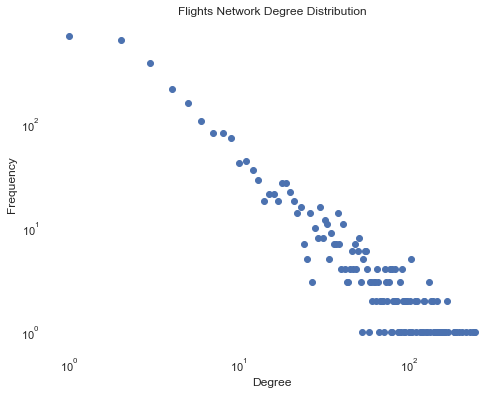

In [74]:
degree_freq = nx.degree_histogram(largest_cc)
degrees = range(len(degree_freq))

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_facecolor('xkcd:white')
plt.loglog(degrees, degree_freq, 'o')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Flights Network Degree Distribution')


### Graph Connectivity

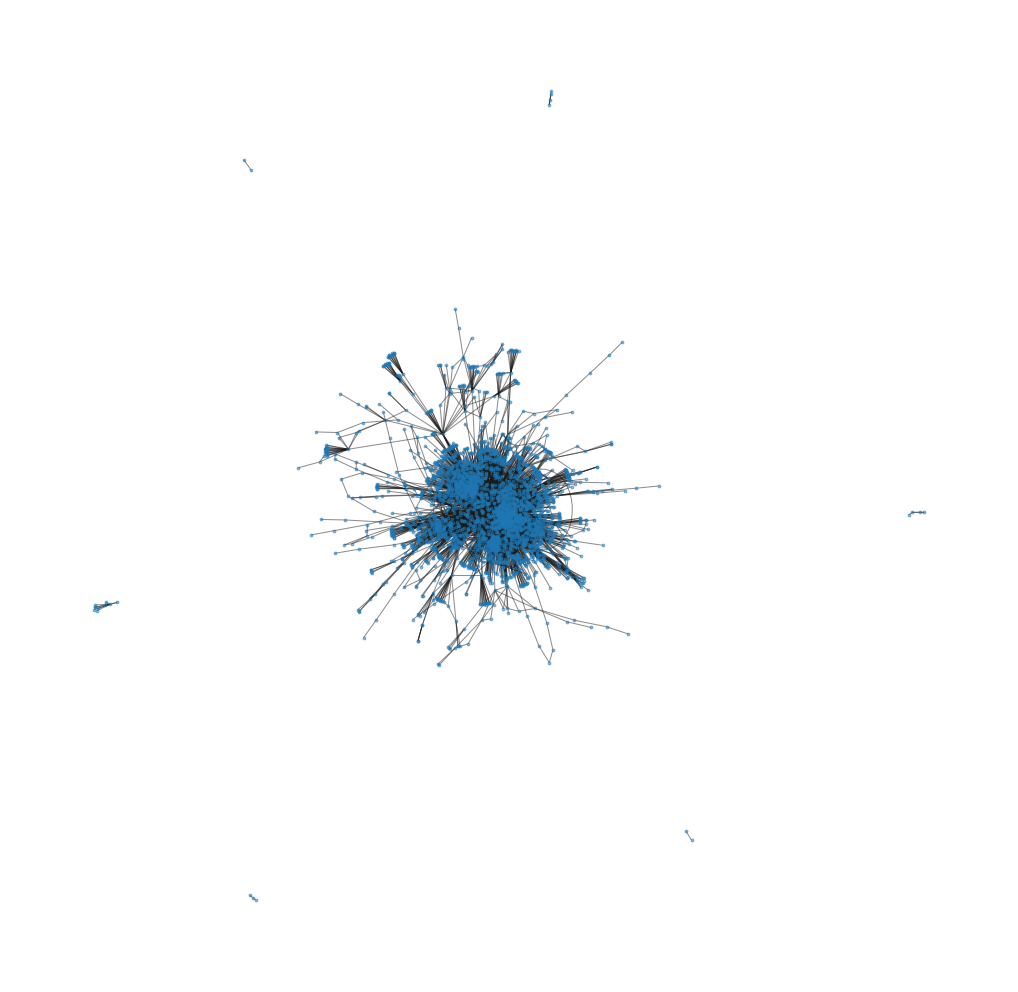

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(18, 18))
nx.draw_networkx(G, ax=ax, node_size=8, with_labels=False, alpha=.5)
ax.set_facecolor('xkcd:white')

In [ ]:
print(f"There are {nx.number_connected_components(G)} different connected components")

There are 7 different connected components


We can see that the network is not fully connected. In fact, we can observe that it is composed of one main connected component as well as 6 other smaller ones. 

To be sure this assumption is right, let's print the amount of nodes each of them have:

In [ ]:
connected_components = nx.connected_components(G)
for connected_component in connected_components:
  print(len(connected_component))

3154
2
3
2
4
4
10


Only the first connected component seems relevant to analyze, the other ones being negligible compared to it. 

Therefore, for simplicity, we will only consider the largest one for the rest of the project.

In [53]:
largest_cc = G.subgraph(max(nx.connected_components(G), key=len))
print(f"The largest component contains {len(largest_cc)} nodes")

The largest component contains 3154 nodes


### Largest Component Diameter

The diameter of a graph is the length of the longest shortest path between all pair of nodes.

In [ ]:
print(f"The diameter of the graph is {nx.diameter(largest_cc)} nodes.")

### Clustering Coefficient

**The neighborhood of a node *u*, is the set of nodes that are connected to it.**

The clustering coefficient of a node ***u*** is the fraction of the node's neighbors that are connected to each other. 

In [ ]:
print(f"The graph has a clustering coefficient of: {nx.average_clustering(largest_cc)}")

A clustering coefficient of about 0.5 means that in average, half of a node's neighbor form a clique. 

### Centrality

Centrality is an indicator of how important can nodes/edges be within a network. 

There are many different centrality measures but we will only consider one of the most common ones, betweeness centrality, eigenvalue centrality and PageRank centrality.

In [ ]:
def get_NameCity(ID):
    row = airports.loc[ID]
    return row['Name'], row['City']

def plot_dict(dict_, k, name):

    def print_rank(l):
        for k in range(len(l)):
            a, b = get_NameCity(l[k])
            print(f"{k+1}. {a}, {b}")

    airports, values = list(dict_.keys()), list(dict_.values())
    sort_index = list(np.argsort(values))
    airports_s = np.array(airports)[sort_index][::-1] #k highest ranked
    values_s = np.array(values)[sort_index][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(14,12))
    ax.set_facecolor('xkcd:white')
    sns.barplot(ax=ax, x=airports_s[:k], y=values_s[:k], palette='rocket', label='small')
    plt.ylabel('Airports Code')
    plt.xlabel('Centraity value')

    print(f"In terms of {name}, the top {k} nodes are:\n")
    print_rank(airports_s[:k])
    return list(zip(airports_s, np.array(range(len(airports_s)))+1))

**Betweenness Centrality**:

Betweenness centrality measures how much nodes/edges are part of shortest paths between pair of nodes.

In [ ]:
betweenness = nx.betweenness_centrality(largest_cc)
sorted_betw = plot_dict(betweenness, 10, 'betweenness')

**Eigenvalue Centrality**:

Eigenvalue centrality measures the nodes' influence in a network. A high eigencentrality value means the node is highly connected to other nodes of great influence.

In [ ]:
eigenval = nx.eigenvector_centrality(largest_cc)
sorted_eigen = plot_dict(eigenval, 10, 'eigenvectors')

**Closeness Centrality**:

Closeness Centrality is calculated as the reciprocal of the sum of the length of the shortest paths between the node and all other nodes in the graph. 

In terms of PageRank, the top 15 nodes are:

1. Frankfurt am Main International Airport, Frankfurt
2. Charles de Gaulle International Airport, Paris
3. London Heathrow Airport, London
4. Amsterdam Airport Schiphol, Amsterdam
5. Dubai International Airport, Dubai
6. Los Angeles International Airport, Los Angeles
7. John F Kennedy International Airport, New York
8. Lester B. Pearson International Airport, Toronto
9. Atatürk International Airport, Istanbul
10. Munich International Airport, Munich
11. Chicago O'Hare International Airport, Chicago
12. Beijing Capital International Airport, Beijing
13. Leonardo da Vinci–Fiumicino Airport, Rome
14. Narita International Airport, Tokyo
15. Newark Liberty International Airport, Newark


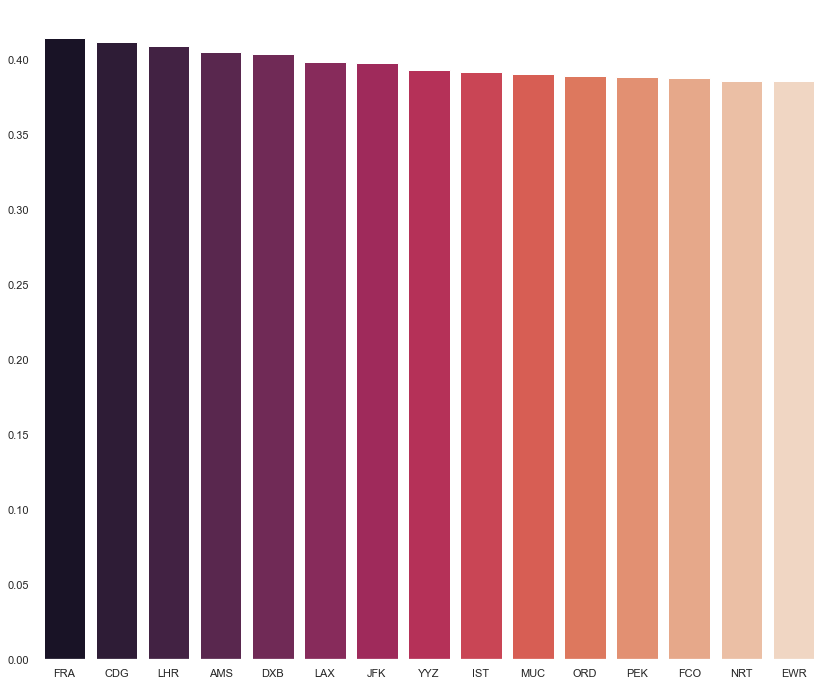

In [ ]:
closeness = nx.closeness_centrality(largest_cc)
sorted_closeness = plot_dict(closeness, 15, 'PageRank')

Now, lets create a dataframe ranking the airports by their importance in the networks considering the above measures.

In [ ]:
betw_df = pd.DataFrame(sorted_betw, columns=['Airport ID', 'Betweenness'])
eigen_df = pd.DataFrame(sorted_eigen, columns=['Airport ID', 'EigenVectors'])
close_df = pd.DataFrame(sorted_closeness, columns=['Airport ID', 'Closeness'])

central_df = [betw_df, eigen_df, close_df]
df_final = reduce(lambda left, right: pd.merge(left, right, on='Airport ID'), central_df)
df_final['Average'] = (df_final['Betweenness'] + df_final['EigenVectors'] + df_final['Closeness'])/3
df_final.sort_values('Average', inplace=True)
df_final.reset_index(drop=True, inplace=True)
df_final['Overall Rank'] = np.array(df_final.index) + 1
df_final.set_index('Airport ID', inplace=True)
city_name = pd.Series(df_final.index).apply(lambda x : str(f"{get_NameCity(x)[0]}, {get_NameCity(x)[1]}"))
df_final.reset_index(inplace=True)
df_final['Airport Name, City'] = city_name
df_final.set_index('Airport ID', inplace=True)
df_final.head(15)

Betweenness  EigenVectors  Closeness    Average  Overall Rank  \
Airport ID                                                                  
CDG                   1             3          2   2.000000             1   
FRA                   5             2          1   2.666667             2   
AMS                   6             1          4   3.666667             3   
LHR                  12             6          3   7.000000             4   
IST                  10             8          9   9.000000             5   
DXB                   3            20          5   9.333333             6   
YYZ                   9            29          8  15.333333             7   
ORD                   8            28         11  15.666667             8   
JFK                  25            18          7  16.666667             9   
LAX                   2            45          6  17.666667            10   
PEK                   7            37         12  18.666667            11   
MUC                  43             4         10  19.000000            12   
MAD                  31            10         18  19.666667            13   
ATL                  19            36         23  26.000000            14   
FCO                  61             5         13  26.333333            15   

                                           Airport Name, City  
Airport ID                                                     
CDG            Charles de Gaulle International Airport, Paris  
FRA         Frankfurt am Main International Airport, Frank...  
AMS                     Amsterdam Airport Schiphol, Amsterdam  
LHR                           London Heathrow Airport, London  
IST                   Atatürk International Airport, Istanbul  
DXB                        Dubai International Airport, Dubai  
YYZ          Lester B. Pearson International Airport, Toronto  
ORD             Chicago O'Hare International Airport, Chicago  
JFK            John F Kennedy International Airport, New York  
LAX            Los Angeles International Airport, Los Angeles  
PEK            Beijing Capital International Airport, Beijing  
MUC                      Munich International Airport, Munich  
MAD              Adolfo Suárez Madrid–Barajas Airport, Madrid  
ATL         Hartsfield Jackson Atlanta International Airpo...  
FCO                 Leonardo da Vinci–Fiumicino Airport, Rome

## World Map

In order to plot the network on a world map, we first need to extract the airports' coordinates.

In [54]:
pos = {airport: (v['Longitude'], v['Latitude'])
    for airport, v in airports.to_dict('index').items()}

In [56]:
# Map projection
def display_map(graph, node_color=None):
    """
    Displays the given graph on the world map. 
    Node_color should be an array of color codes handled by the cartopy library
    indicating each airports' color. It is used to differeiate different clusters.
    """
    fig, ax = plt.subplots(1, 1, figsize=(36, 24), 
        subplot_kw=dict(projection=ccrs.PlateCarree()))
    ax.coastlines()
    ax.set_facecolor('xkcd:white')

    # A node's size will only consider it's degree.
    degree = nx.degree(graph)
    node_sizes = [5 * degree[iata] for iata in graph.nodes]

    # Only the biggest nodes' labels will be displayed.
    node_labels = {iata: iata if degree[iata] >= 200 else '' for iata in graph.nodes}

    nx.draw_networkx(graph, ax=ax, font_size=18, font_weight='bold', alpha=0.5, width=0.1,
        node_size=node_sizes, labels=node_labels,  pos=pos, node_color=node_color, edge_color='dimgray')

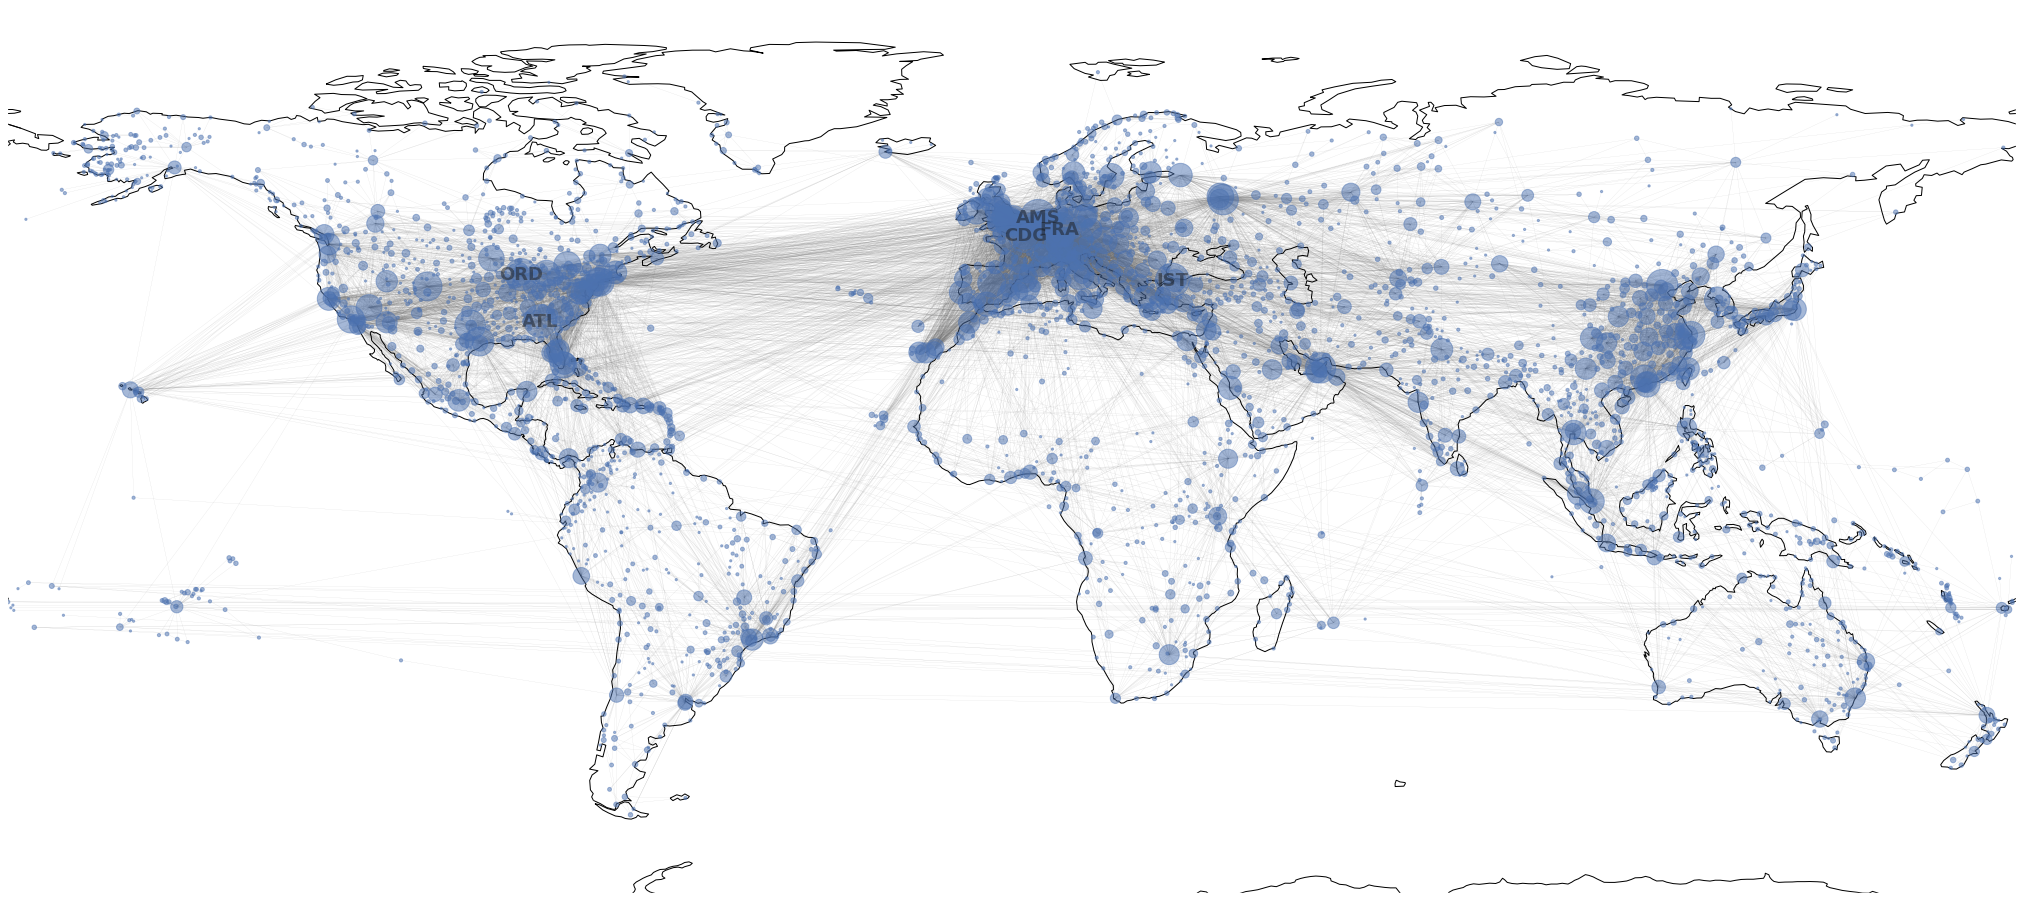

In [ ]:
display_map(largest_cc)

## Finding Communities

### Spectral Clustering

Sepctral Clustering is a technique useful for finding the amounts of communities that can be found within a network. More than just computing the number of connected componenents, it also gives an idea of how close the network is drom being divided into several smaller ones.

#### Laplacian's eigenvalues

The first step is to compute the network's normalized Laplacian matrix, extract its eigenvalues and then plot the first ones, the smallest ones by nature. 

In [ ]:
def plot_laplacian_eigenvalues(graph, n=20):
    """
    Computes the Laplacian's eigenvalues from the given graph and plots the first n one.
    """
    # Calculating the graph's Laplacian matrix
    laplacian = nx.normalized_laplacian_matrix(graph) 

    # Calculating the Laplacian's eigenvalues
    ev, _ = scipy.linalg.eigh(laplacian.toarray())

    # Ploting the eigenvalues
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.set_facecolor('xkcd:white')
    plt.plot(ev[:n], '+-')
    plt.ylabel('Value')
    plt.xlabel('Index')
    plt.grid(False)
    plt.title("Laplacian's eigenvalues")

    plt.show()

Let's try this on the original cleaned graph, G, who has 7 connected components.

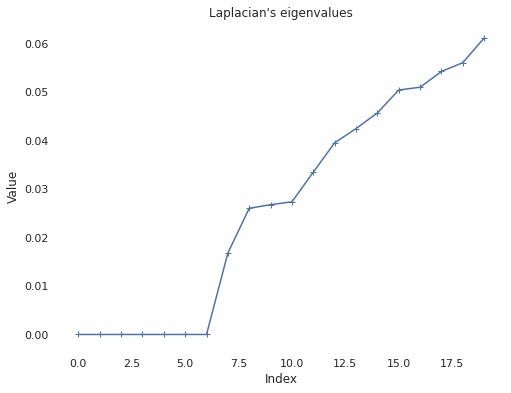

In [ ]:
plot_laplacian_eigenvalues(G)

The first zero eigenvalues correspond to the number of connected components the graph has. As we expected here, we again get 7 of them.



Now, let's try on our main network, largest_cc.

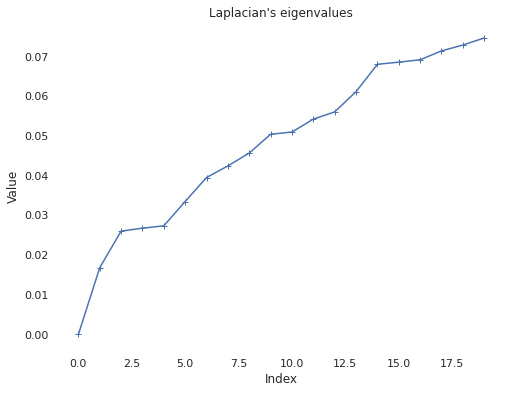

In [ ]:
plot_laplacian_eigenvalues(largest_cc)

As expected, this time we obtain that the network only has one connected component.

However, usually, the analysis doesn't stop here. Indeed, this plot can also give an idea of how close the network can be divided into several connected components by identifying what is called the **spectral gap**.

The spectral gap is essentially the first "big" gap between eigenvalues that seperates the ones that are "close" to zero from the others. The number of nonzero eigenvalues found before this spectral gap will in fact define the number of communities that can be found within the network.

Here, this spectral gap unfortunately seems to occur between the first and seconc eigenvalue, which indicates that **no relevant communities can be found in our network using Spectral Clustering**. 

This is in fact not very surprising. Spectral Clustering only finds groups of nodes that are connected to each other but not so well connected to others. However, we've seen before that our network is highly connected, especially between continents. Therefore,  we only expect to find **small regional isolated airline networks** that have few connections with the rest of the world.


Nevertheless, lets try to display some communities on our world map. 

#### Plotting clusters on the map


First, here are functions that will turn very useful fore providing each clusters a different color on the map.

In [69]:
def get_colors_for_map(number_of_clusters):
  """
  Returns number_of_clusters different color codes handled by the cartopy library.
  """
  cmap = plt.cm.get_cmap('gist_rainbow')
  rgba = np.linspace(0.0, 1.0, num=number_of_clusters)
  return [cmap(x) for x in rgba]

def get_cluster_colors(cluster_labels, number_of_clusters=10):
    """
    Converts the cluster label values to color codes handled by the cartopy library.
    """
    colors = get_colors_for_map(number_of_clusters)
    colored_labels = []
    for cluster_label in cluster_labels:
        colored_labels.append(colors[cluster_label])

    return colored_labels

In order to apply spectral clustering in our network, we will use the method given by the **sklearn library**. 

There are several ways to use this technique. Here we consider the adjacency matrix as an affinity matrix that we give as an input to the method. Also, labels are assigned to different clusters using a **discretization approach** and not the popular kmeans one, which doesn't work very well for non-spherical graphs like we have.

In [ ]:
def spectral_clustering(graph, number_of_clusters=5):
    """
    Applies Spectral Clustering on the given graph and returns the labeled clusters
    as an array. 
    For example, a network of 4 nodes and two clusters could give this output: [0,1,1,0]. 
    The first and last airport are part of cluster 0 while the two others are part 
    of cluster 1.
    """
    adjacency_mat = nx.to_numpy_matrix(graph)
    cluster_labels = SC(n_clusters=number_of_clusters, affinity='precomputed', 
        assign_labels='discretize').fit(adjacency_mat).labels_

    return cluster_labels


In fact, in order to properly use this technique, we need to give the method a number of expected clusters. 

If we observe the last previous plot, we can see that the third, fourth and fifth eigenvalues are very close to each other compared to the sixth one. We can start by assuming that a smaller spectral gap can be found between the fifth and sixth one. 

Therefore, we will first **try to find 5 communities**.

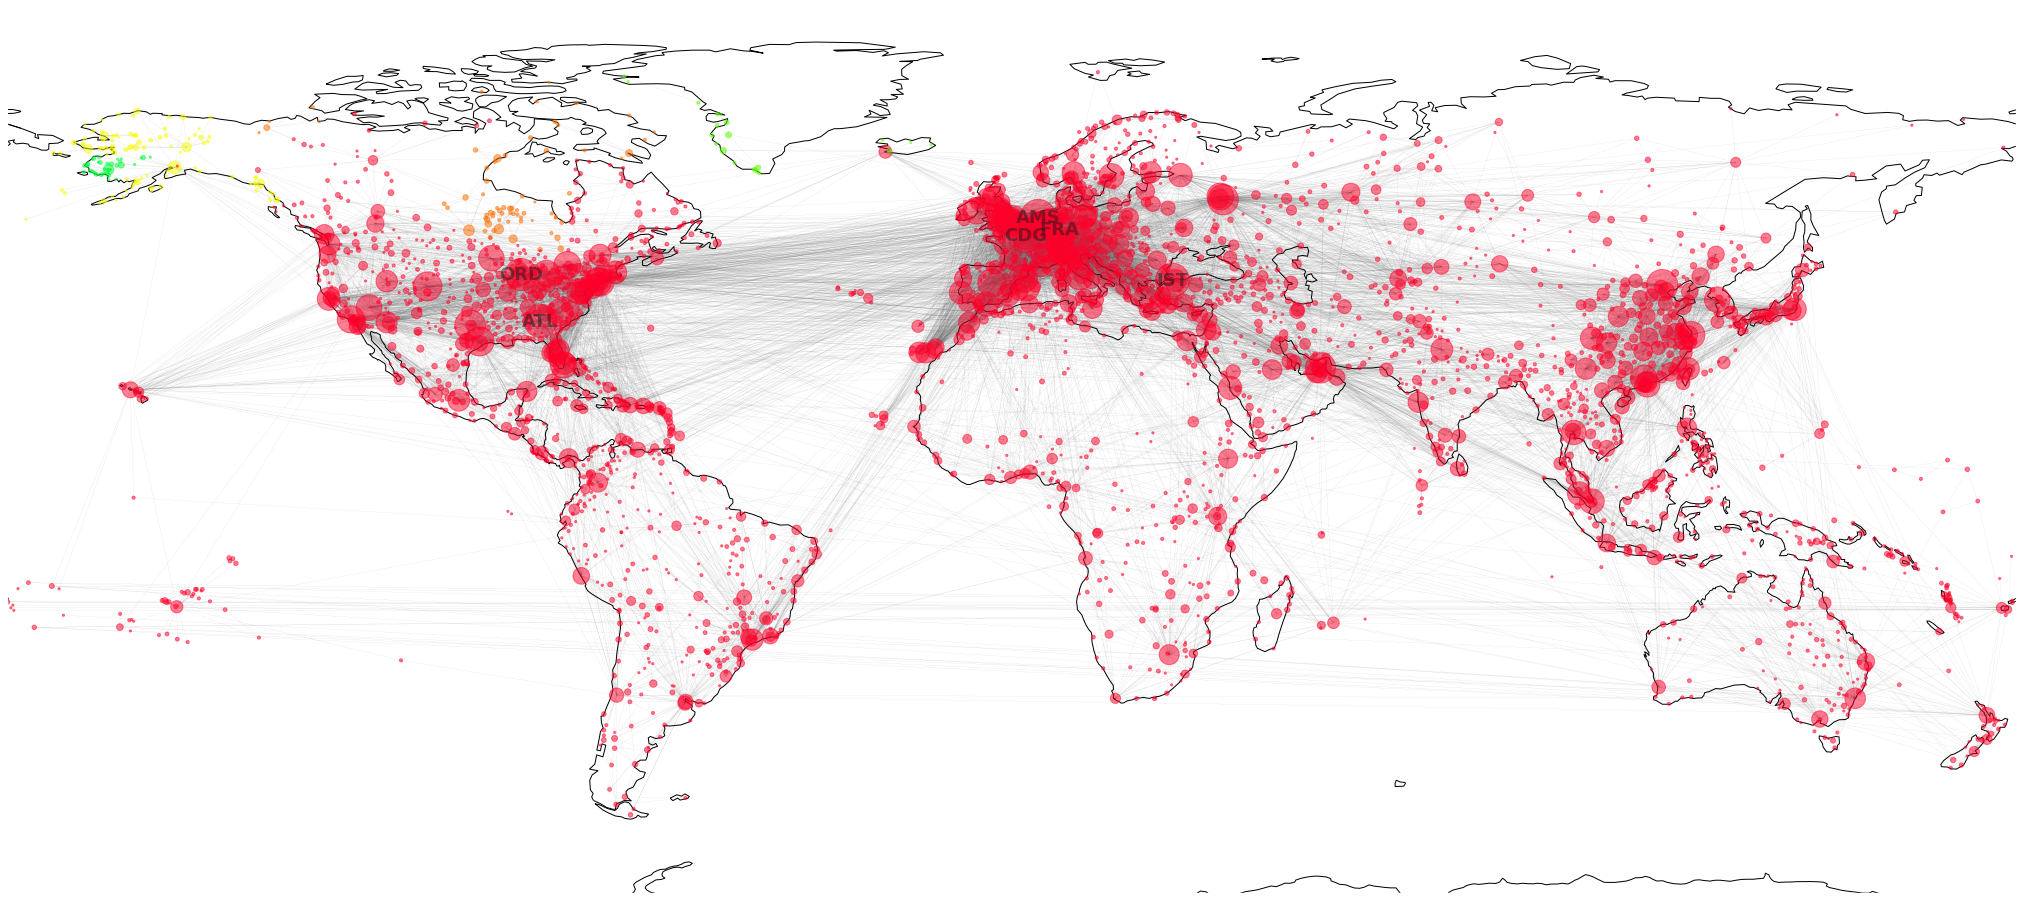

In [ ]:
sc_labels_5 = spectral_clustering(largest_cc, 5)
sc_clusters_5 = get_cluster_colors(sc_labels_5)
display_map(largest_cc, sc_clusters_5)

As we expected, only small regional isolated airline networks were found, Alaska, Greenland and a part of Northern Canada.

Now, let's try with **10 communities**.

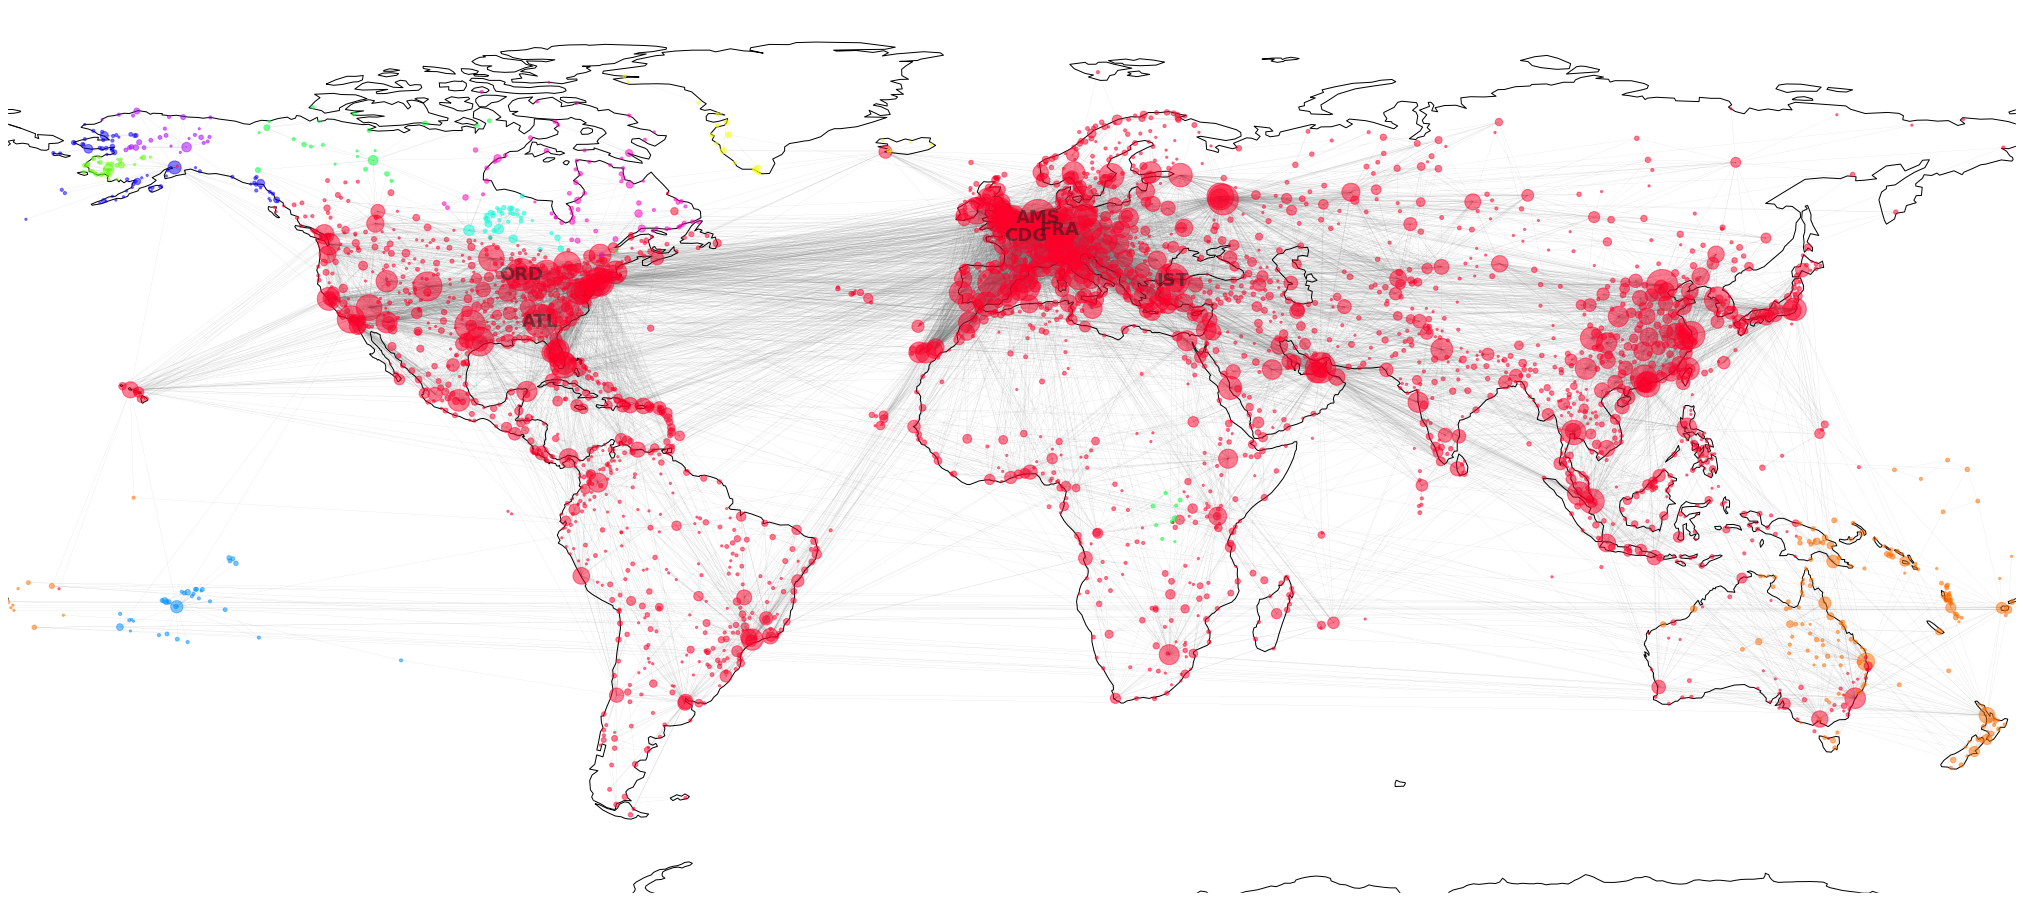

In [ ]:
sc_labels_10 = spectral_clustering(largest_cc, 10)
sc_clusters_10 = get_cluster_colors(sc_labels_10)
display_map(largest_cc, sc_clusters_10)

The result didn't change much, only new less isolated regional airline networks were found, like French Polynesia for example. 

Still, we can see that a **big part of Oceania has been identified as a community of its own**, which is a good start.

#### Clustering Precision

In order to have an idea of how good our clustering algorithm is good, we need to evaluate its precision using different metrics: 
- **Coverage**: The coverage of a partition is the ratio of the number of intra-community edges to the total number of edges in the graph. 
- **Performance**: The performance of a partition is the number of intra-community edges plus inter-community non-edges divided by the total number of potential edges. High values mean that clusters are both internally dense and externally sparse.
- **Modularity**: The modularity measures the portion of the edges of the network that connect nodes within communities minus the same expected value in a identically divised network but that only considers random connections between vertices. A large value (close to 1) indicates strong connections within communities and sparse ones between them. However, it doesn't really work with small communities.

In [57]:
def clustering_precision(graph, partition):
  """
  Computes and prints the different clustering precision measures for the given partition. 
  """
  coverage, performance = nx.algorithms.community.quality.partition_quality(largest_cc, partition)
  modularity = nx.algorithms.community.quality.modularity(largest_cc, partition)

  print(f'This partition has a coverage of {coverage:.4f}, a performance of '
      f'{performance:.4f} and a modularity of {modularity:.4f}.' )
  
  # return coverage, performance, modularity


Let's compute those measures for the first partition.

In [58]:
def create_partition_from_labels(graph, cluster_labels):
  """
  Stores the airports' name in different lists representing the different communities.
  """
  labels = defaultdict(list)
  for node, label in zip(graph.nodes, cluster_labels):
      labels[label].append(node)

  return list(labels.values())

In [ ]:
sc_partition_5 = create_partition_from_labels(largest_cc, sc_labels_5)
clustering_precision(largest_cc, sc_partition_5)

This partition has a coverage of 0.9973, a performance of 0.1368 and a modularity of 0.0354.


As expected, the performance and modularity are very low, indicating a bad clustering partition. 

Considering the coverage's high score, wich typically should indicate a very strong clustering partition, this can be explained by the fact that the main connected component's weight in the computation is predominant compared to the other communities, it has a lot more intra-community edges than those last ones. This result is therefore not relevant at all.

### Modularity Maximization

One other way to detect communities within a graph is by maximizing the **modularity** using the **Greedy Modularity Maximization** method.

The idea is to compute this measure for all possible partitions and then pick the one with the highest value. However, this has a time complexity of O(N^2), which can take quite some time for networks with many nodes.

Fortunately, ours is not so large and the computation only takes less than 30 seconds.

#### Greedy Modularity Maximization

In [66]:
def get_cluster_colors_from_partition(graph, partition, number_of_clusters=None):
    """ 
    Creating the color list used for the map display from the given graph partition.

    All clusters smaller than the nth one (n being number_of_clusters) will be 
    colored in gray (as long as the partition is ordered by descending order).
    """
    # In case all clusters should be displayed.
    if number_of_clusters is None:
        number_of_clusters = len(partition)

    colors = get_colors_for_map(number_of_clusters)
    cluster_colors = []

    # Iterating on the nodes so that the order is kept
    for node in graph.nodes:
        for i in range(number_of_clusters):

            # If the node is from one of te desired clusters
            if node in partition[i]:
                cluster_colors.append(colors[i])
                break

        # If the node is not from one of the desired clusters
        else:
            cluster_colors.append((0.5, 0.5, 0.5))
    
    return cluster_colors

In [ ]:
gmc_partition = nx.algorithms.community.greedy_modularity_communities(largest_cc)

In [ ]:
print(f"The GMC algorithm found {len(gmc_partition)} clusters.")
print(f"The first cluster has {len(gmc_partition[0])} nodes while the last one only has {len(gmc_partition[-1])} nodes.")

The GMC algorithm found 37 clusters.
The first cluster has 864 nodes while the last one only has 2 nodes.


37 different clusters were found, ordered from the biggest to the smallest ones. Therefore, we will only consider the first 5 of them.

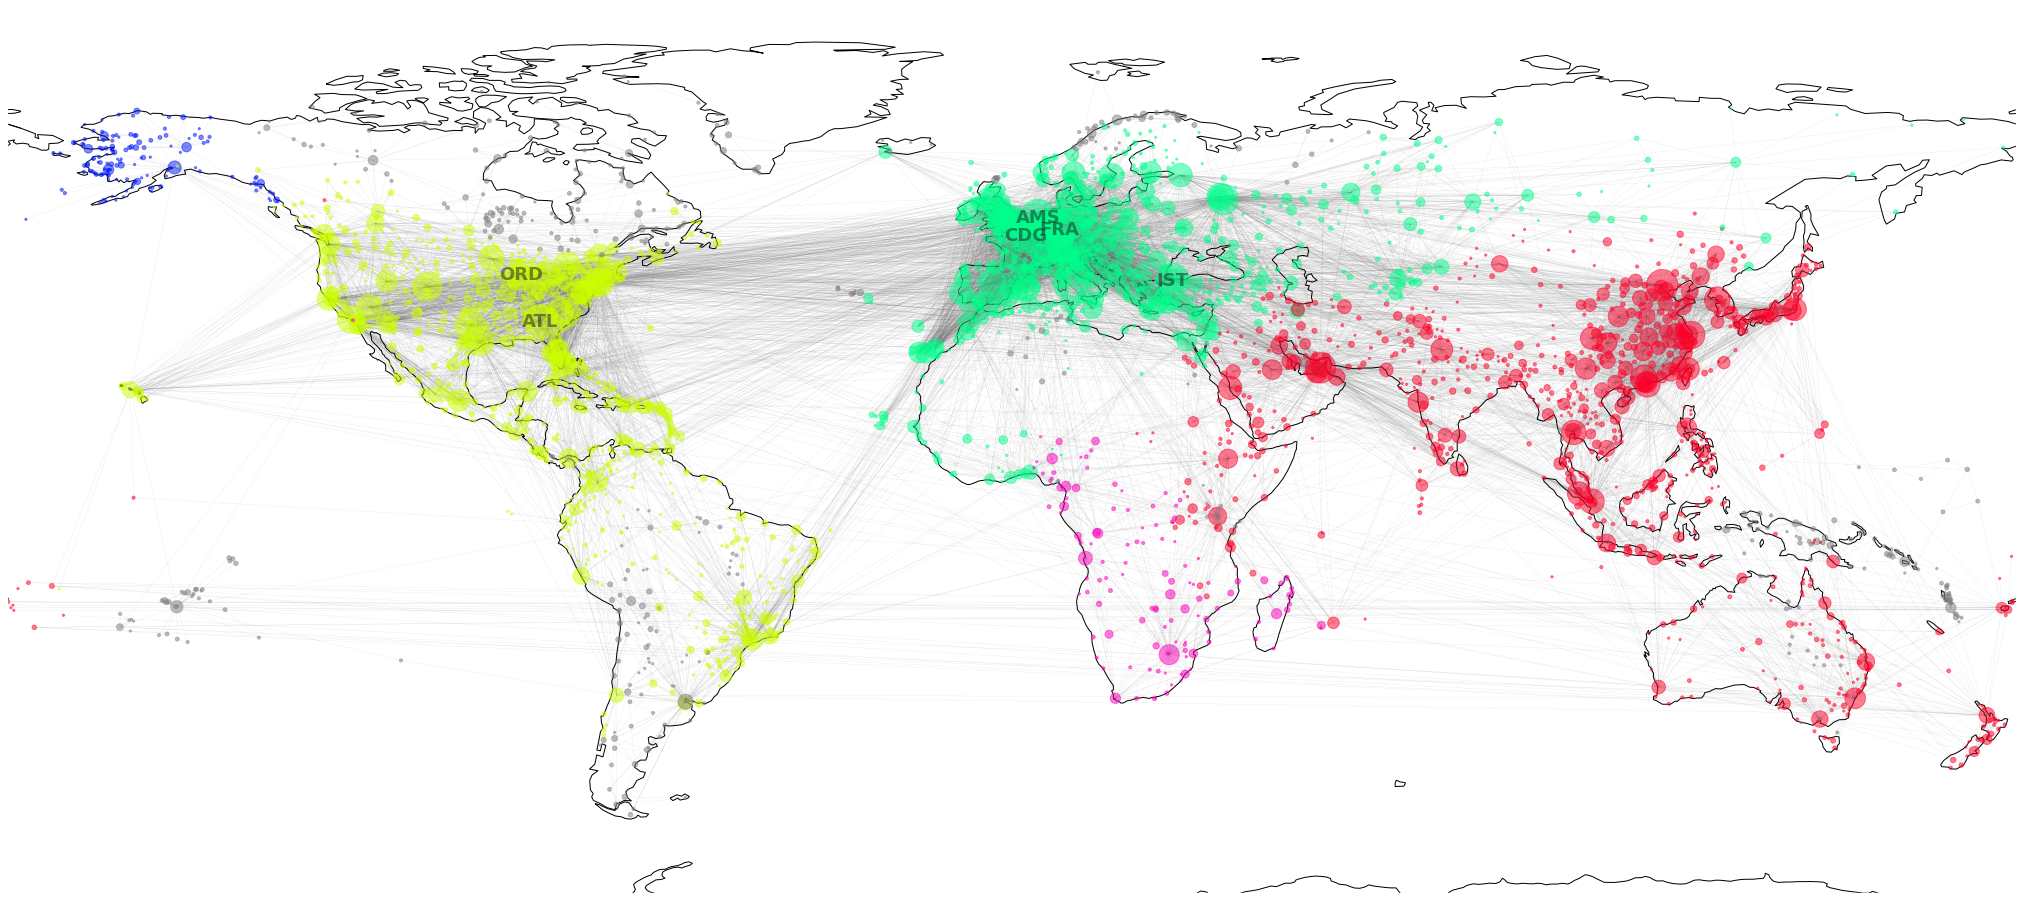

In [ ]:
gmc_clusters = get_cluster_colors_from_partition(largest_cc, gmc_partition, number_of_clusters=5)
display_map(largest_cc, node_color=gmc_clusters)

Modularity maximization seems to give much better results, if we only consider the bigger clusters. Indeed, we can clearly start to differentiate our world continents, especially America. 

However, we still observe some issues. For example, Alaska is still considered as a community by itself because of its significant isolation. Also, Europe is identified much bigger than it's supposed to be, spreading through Asia and Africa, while Oceania is attached to Asia's network.

In [ ]:
clustering_precision(largest_cc, gmc_partition)

This partition has a coverage of 0.9060, a performance of 0.7969 and a modularity of 0.6040.


We can observe that, indeed, the modularity value is way higher than before. However, it still remains at around 0.6, which can definitively be improved with other algorithms.

### Louvain

The **Louvain** method is also a greedy method based on optimizing modularity. The idea is, first, to find small local communities and then group them together to create bigger ones. 

It has a time complexity of O(N.log N).

In [68]:
def create_partition_from_partition_dict(partition_dict):
    """
    Creating a proper graph partition from the given partition dict.
    """
    partition = defaultdict(list)
    for node in partition_dict:
        partition[partition_dict[node]].append(node)
    
    return list(partition.values())


In [ ]:
louvain_partition_dict = cmt.best_partition(largest_cc)
louvain_partition = create_partition_from_partition_dict(louvain_partition_dict)

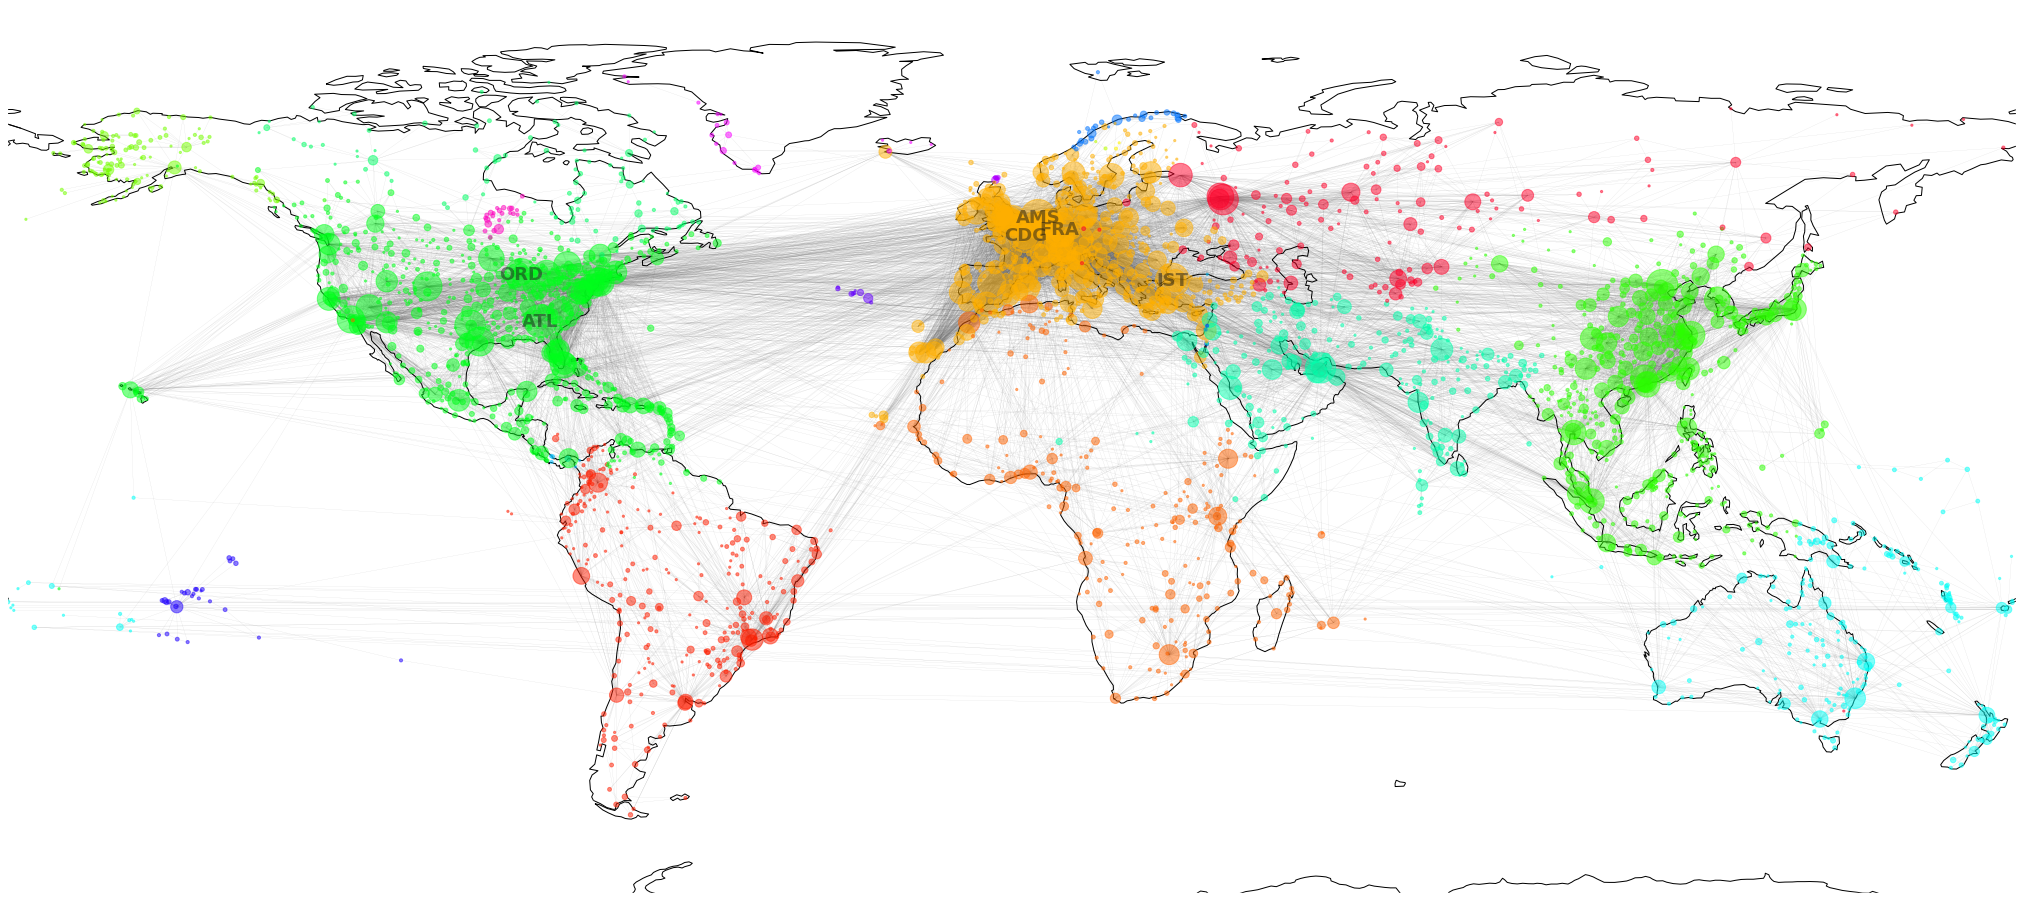

In [ ]:
louvain_clusters = get_cluster_colors_from_partition(largest_cc, louvain_partition)
display_map(largest_cc, node_color=louvain_clusters)

The result seems better than with the Greedy Modularity Communities.  Although a lot of small communities are still found and Asia is separated into three big clusters, we can see that Oceania, Europe, Africa, North and South America are well distinguished. 

In [ ]:
clustering_precision(largest_cc, louvain_partition)

This partition has a coverage of 0.8648, a performance of 0.8783 and a modularity of 0.6582.


As expected, the modularity mectric is a bit higher than previously. Also, the performance is now excellent. 

Some improvements can still be made, especially by trying to increase modularity, but the result is already acceptable.

### Girvan-Newman

The idea of the Girvan-Newman algorithm is to progressively "remove" edges that are likely to be between different communities, in particular by using the betweeness centratily metric. 

However, computing that measure is highly computing intensive, making the algorithm's time complexity O(N.E^2).


In [62]:
def Girvan_Newman(graph, number_of_communities=30):
  partitions = []

  # The current partition of the graph
  partition = [graph.copy()] 

  while len(partition) != number_of_communities:
      # Chosing the biggest subgraph
      partition.sort(key=lambda x: len(x), reverse=True)
      graph_to_divide = partition[0]
      partition.pop(0)
      print(f"Communities: {len(partitions) + 1}")
    
      edges_removed = 0
      # While the graph is still fully connected
      while nx.is_connected(graph_to_divide):
          # Randomly removing 15% of edges
          edges = list(graph_to_divide.edges)
          random.shuffle(edges)
          edges_to_remove = edges[:int(0.15*len(edges))]
          graph_to_divide.remove_edges_from(edges_to_remove)

          # Finding and removing an edge based on betweenness centrality metrics
          centrality = nx.edge_betweenness_centrality(graph_to_divide)
          sorted_centrality = sorted(
              centrality.items(), 
              key=operator.itemgetter(1), 
              reverse=True
          )
          graph_to_divide.remove_edge(
              sorted_centrality[0][0][0], 
              sorted_centrality[0][0][1]
          )
          edges_removed += 1
          print(f'Removed edges: {edges_removed}')
          # Adding the previously removed edges
          graph_to_divide.add_edges_from(edges_to_remove)

      # The initial graph is now divided into two subgraphs, creating a new partition
      partition += list(
          graph_to_divide.subgraph(communities).copy() 
          for communities in nx.connected_components(graph_to_divide)
      )
      partitions.append(partition)

  return partitions

In [60]:
def get_old_partition(subgraphs):
    partition = []
    for graph in subgraphs:
        nodes = set(graph[0].nodes)
        partition.append(nodes)
    return partition

Since the GMC algorithm found 37 different communities, we should expect a similar result. Indeed, considering the way the Girvan Newman works, it will also find a lot small ones. Therefore, we decided to run it 

In [63]:
gn_partitions = Girvan_Newman(largest_cc, 37)

Communities: 1
Removed edges: 1
Removed edges: 2
Removed edges: 3
Removed edges: 4
Removed edges: 5
Removed edges: 6
Removed edges: 7
Removed edges: 8
Removed edges: 9
Removed edges: 10
Removed edges: 11
Removed edges: 12
Removed edges: 13
Removed edges: 14
Removed edges: 15
Communities: 2
Removed edges: 1
Removed edges: 2
Communities: 3
Removed edges: 1
Removed edges: 2
Removed edges: 3
Removed edges: 4
Removed edges: 5
Removed edges: 6
Removed edges: 7
Removed edges: 8
Removed edges: 9
Removed edges: 10
Removed edges: 11
Removed edges: 12
Removed edges: 13
Removed edges: 14
Removed edges: 15
Removed edges: 16
Removed edges: 17
Communities: 4
Removed edges: 1
Removed edges: 2
Removed edges: 3
Removed edges: 4
Removed edges: 5
Communities: 5
Removed edges: 1
Removed edges: 2
Removed edges: 3
Removed edges: 4
Removed edges: 5
Removed edges: 6
Removed edges: 7
Removed edges: 8
Communities: 6
Removed edges: 1
Removed edges: 2
Removed edges: 3
Removed edges: 4
Removed edges: 5
Removed edge

In [64]:
# Since the algorithm takes a long time, the results are saved in a file.
# Saving the results
np.save("subgraphs", subgraphs)

#subgraphs = np.load("subgraphs.npy", allow_pickle=True)
gn_partition = get_old_partition(subgraphs)

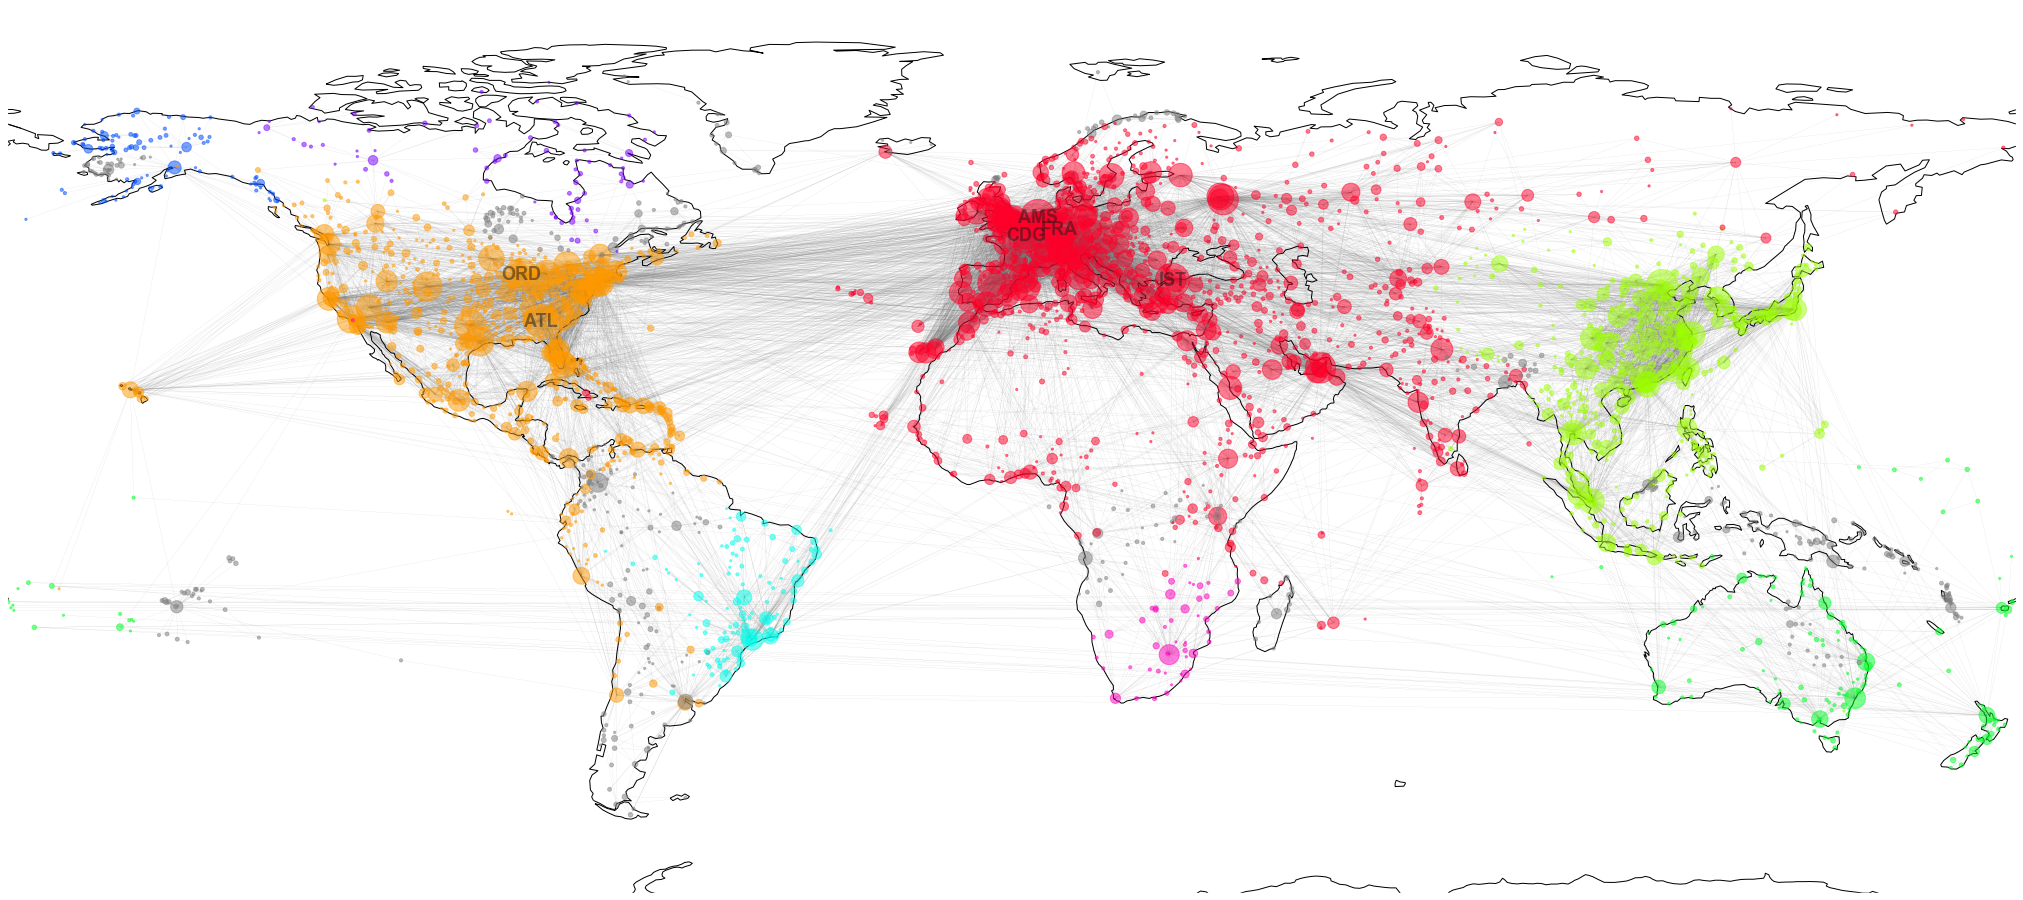

In [70]:
gn_clusters = get_cluster_colors_from_partition(largest_cc, gn_partition, 8)
display_map(largest_cc, gn_clusters)

# Making use of edge betweenness to find communities yields good results.  

In [71]:
clustering_precision(largest_cc, gn_partition)

This partition has a coverage of 0.9108, a performance of 0.8198 and a modularity of 0.5944.
